In [1]:
pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import shutil
from shutil import unpack_archive
from PIL import Image, ImageOps  
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import plotly.graph_objects as go
import plotly.express as px
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
pio.templates.default = 'plotly_white'
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, MaxPooling2D, Conv2D
from  tensorflow.keras.preprocessing.image import ImageDataGenerator


#import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

from tensorflow.keras import layers
#import efficientnet.tfkeras as efn
from tqdm import tqdm_notebook
from tensorflow.keras.applications import EfficientNetB7 as efn

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
data_dir = '/content/drive/MyDrive/dataset/Citra BISINDO/'
IMAGE_SIZE = [224, 224]
train='/content/drive/MyDrive/dataset/Citra BISINDO'
val='/content/drive/MyDrive/dataset/Citra BISINDO'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=32)

Found 312 files belonging to 26 classes.
Using 250 files for training.
Found 312 files belonging to 26 classes.
Using 62 files for validation.


In [11]:
IMAGE_SIZE = 224

In [12]:
size = (IMAGE_SIZE, IMAGE_SIZE)
ds_train = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [13]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [14]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
no_epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [15]:
#Creating an EffNet model
model_B7 = efn(weights='imagenet', input_shape=input_shape, include_top=False)

In [16]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train,
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(val,
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

pretrained_model = model_B7
pretrained_model.trainable=True
set_trainable=False

for layer in pretrained_model.layers:
    if layer.name == 'block7c_project_conv':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False


model=Sequential()
model.add(pretrained_model)
model.add(MaxPooling2D(name="MaxPool_"))
model.add(Dropout(0.2, name="dropout_out"))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=[metrics.AUC(name='auc'), 'accuracy'])

es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//batch_size,
                    callbacks= [es_callback],
                    verbose=verbosity)

Found 312 images belonging to 26 classes.
Found 312 images belonging to 26 classes.
Epoch 1/15
4/4 [==============================] - 258s 67s/step - loss: -414.5937 - auc: 0.5000 - accuracy: 0.0403 - val_loss: -878.4743 - val_auc: 0.5000 - val_accuracy: 0.0391
Epoch 2/15
4/4 [==============================] - 227s 65s/step - loss: -1974.4282 - auc: 0.5000 - accuracy: 0.0403 - val_loss: -2217.7168 - val_auc: 0.5000 - val_accuracy: 0.0430
Epoch 3/15
4/4 [==============================] - 241s 66s/step - loss: -3465.2168 - auc: 0.5000 - accuracy: 0.0430 - val_loss: -3629.3550 - val_auc: 0.5000 - val_accuracy: 0.0352
Epoch 4/15
4/4 [==============================] - 223s 63s/step - loss: -5101.1611 - auc: 0.5000 - accuracy: 0.0444 - val_loss: -6702.5913 - val_auc: 0.5000 - val_accuracy: 0.0312
Epoch 5/15
4/4 [==============================] - 237s 68s/step - loss: -6799.9531 - auc: 0.5000 - accuracy: 0.0403 - val_loss: -9395.5986 - val_auc: 0.5000 - val_accuracy: 0.0391
Epoch 6/15
4/4 [==

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['auc'],
                         line=dict(color='firebrick', width=2, dash='dash'), name='AUC'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_auc'],
                         line=dict(color='turquoise', width=2), name='validation AUC'))

fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'],
                         line=dict(color='orange', width=2, dash='dash'), name='accuracy'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'],
                         line=dict(color='green', width=2), name='validation accuracy'))

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs')
fig.show()

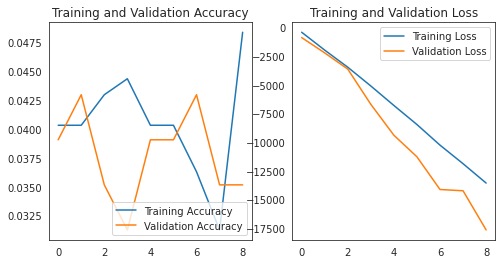

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

class_names = tuple(train_ds.class_names)
uploaded = files.upload()
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  predictions = model.predict(images, batch_size=32)
  score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} \nWith a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

MessageError: ignored